## PREPARING DATASETS

In [4]:
import pandas as pd
# Read in track metadata with genre labels
tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics = pd.read_json('datasets/echonest-metrics.json')

# Merge relevant column of tracks and echonest metrics

echo_tracks = echonest_metrics.merge(tracks[['track_id', 'genre_top']], on='track_id')

print(echo_tracks)

echo_tracks.info()


      track_id  acousticness  danceability    energy  instrumentalness  \
0            2      0.416675      0.675894  0.634476      1.062807e-02   
1            3      0.374408      0.528643  0.817461      1.851103e-03   
2            5      0.043567      0.745566  0.701470      6.967990e-04   
3          134      0.452217      0.513238  0.560410      1.944269e-02   
4          153      0.988306      0.255661  0.979774      9.730057e-01   
...        ...           ...           ...       ...               ...   
4797    124718      0.412194      0.686825  0.849309      6.000000e-10   
4798    124719      0.054973      0.617535  0.728567      7.215700e-06   
4799    124720      0.010478      0.652483  0.657498      7.098000e-07   
4800    124721      0.067906      0.432421  0.764508      1.625500e-06   
4801    124722      0.153518      0.638660  0.762567      5.000000e-10   

      liveness  speechiness    tempo   valence genre_top  
0     0.177647     0.159310  165.922  0.576661   Hip

## Normalizing the feature data

In [6]:
# Define our features 
features = echo_tracks.drop(['genre_top', 'track_id'], axis=1)

# Define our labels
labels = echo_tracks['genre_top']

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

## Principal Component Analysis on our scaled data

Here we calculate the  cumulative explained variance plot to determine how many features are required to explain (95% of the variance). Once we determine the appropriate number of components, we can perform PCA with that many components, ideally reducing the dimensionality of our data



[0.24297674 0.4234199  0.55992299 0.68986388 0.80042636 0.88344881
 0.95268664 1.        ]


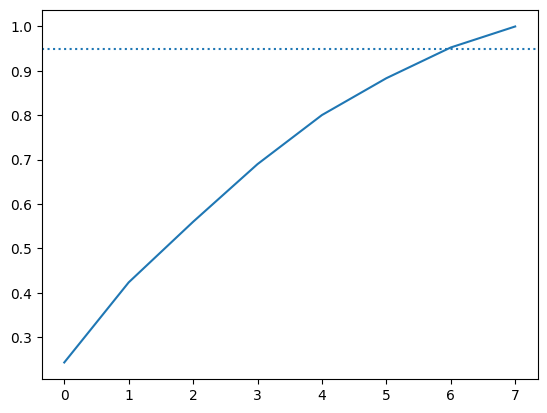

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)
print(cum_exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.95.
fig, ax = plt.subplots()
ax.plot(range(pca.n_components_), cum_exp_variance)
ax.axhline(y=0.95, linestyle=':')
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

## Train a decision tree to classify genre

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)

# Train our decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)

# Create the classification report for models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
print("Decision Tree: \n", class_rep_tree)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201



looking at our classification report, we can see that rock songs are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs.
-> Data points for Rock is far from Hip-Hop
But the problem is this also tells us that most of our model's accuracy is driven by its ability to classify just rock songs, which is less than ideal.

## Idea of balancing our dataset

In [13]:
# Subset only the hip-hop tracks, and then only the rock tracks
hiphop_only = echo_tracks.loc[echo_tracks["genre_top"] == "Hip-Hop"]

# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = echo_tracks.loc[echo_tracks["genre_top"] == "Rock"].sample(len(hiphop_only), random_state=10)

# concatenate (kết nối) the dataframes rock_only and hiphop_only
rock_hop_bal = pd.concat([rock_only, hiphop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)

# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

# Create the classification report for models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.74      0.73      0.74       230
        Rock       0.73      0.74      0.73       225

    accuracy                           0.74       455
   macro avg       0.74      0.74      0.74       455
weighted avg       0.74      0.74      0.74       455



We've now balanced our dataset, but in doing so, we've removed a lot of data points that might have been crucial to training our models.
-> Reduce models average precision.
However it success in improve model bias. To get a good sense of how well our models are actually performing, we can apply what's called cross-validation (CV). This step allows us to compare models in a more rigorous fashion.

## Using cross-validation to evaluate our models

In [17]:
from sklearn.model_selection import KFold, cross_val_score
# Set up our K-fold cross-validation
kf = KFold(n_splits= len(train_features))
# Train our models using KFold cv
tree = DecisionTreeClassifier(random_state=10)
tree_score = cross_val_score(tree, test_features, test_labels, cv = 10)
#Print the mean of array of scores
print("Decision Tree:", tree_score)

Decision Tree: [0.67391304 0.76086957 0.82608696 0.7826087  0.7826087  0.86666667
 0.73333333 0.64444444 0.84444444 0.77777778]
